In [1]:
# Gibeom Lee, HI Lab
# Ïù¥ ÏΩîÎìúÎäî ACÏùò frequency Î•º Ï∏°Ï†ïÌï¥Ï£ºÎäî ÏΩîÎìúÏûÖÎãàÎã§.
#

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter

In [3]:
# 1. ÏÇ¨Ïö©Ïûê ÏûÖÎ†•Í∞í
file_path = r"c:\Users\limye\OneDrive - gachon.ac.kr\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\0. Ïã§ÌóòÏûêÎ£å\4. Data measurement\250810_ÏùºÎã® Ï†ÑÏïïÏ†ÑÎ•ò\csvÌååÏùº\minimized_Ï†ÑÎ•ò\A_aloe_4_10uAV.csv"

# ÏÑ§Ï†ïÍ∞í
prominence_ratio = 0.3 # Ïã†Ìò∏Ïùò ÌëúÏ§ÄÌé∏Ï∞®(std)Ïóê Í≥±Ìï¥ ÌîºÌÅ¨ prominence Í∏∞Ï§ÄÏùÑ ÏÑ§Ï†ï / Ï£ºÎ≥Ä Í∞íÎ≥¥Îã§ ÏñºÎßàÎÇò ÎèåÏ∂úÎêú Ï†ïÎèÑÏó¨Ïïº ÌîºÌÅ¨Î°ú Ïù∏ÏãùÌï†ÏßÄÎ•º Í≤∞Ï†ï
min_prominence = 0.1 # prominenceÏùò ÏµúÏÜüÍ∞í Ï†úÌïú / stdÍ∞Ä ÎÑàÎ¨¥ ÏûëÏïÑÏÑú prominenceÍ∞Ä ÎÑàÎ¨¥ ÎÇÆÍ≤å Í≥ÑÏÇ∞ÎêòÎäî Í≤ΩÏö∞Î•º Î∞©ÏßÄ
min_distance_sec = 0.2 #Ïù∏Ï†ëÌïú ÌîºÌÅ¨ Í∞Ñ ÏµúÏÜå ÏãúÍ∞Ñ Í∞ÑÍ≤© (Ï¥à Îã®ÏúÑ)
snr_threshold = 1 # Signal-to-Noise Ratio Í∏∞Ï§ÄÍ∞í / Í∞íÏù¥ ÎÜíÏùÑÏàòÎ°ù Í∞ïÌïú ÌîºÌÅ¨Îßå ÌÜµÍ≥º
min_relative_height = 0.05  # Ï†ÑÏ≤¥ ÏµúÎåÄ ÏßÑÌè≠Ïùò 20% Ïù¥ÏÉÅ

üìä ÏÉòÌîåÎßÅ ÏÜçÎèÑ: 50000.23 Hz
Vpp_avg = -1.94
üîÅ ÌèâÍ∑† Ï£ºÌååÏàò: 4.39 Hz
‚úî ÏµúÏ¢Ö ÌîºÌÅ¨ Ïàò: 9


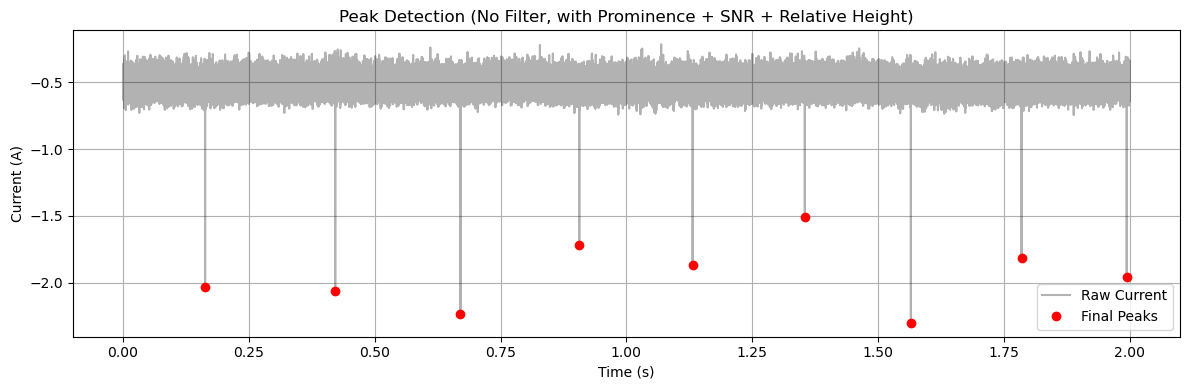

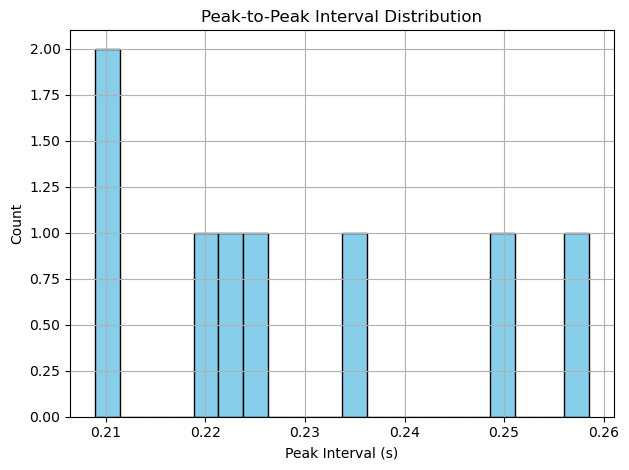

In [4]:
# -------------------------------
# 2. CSV Î°úÎî© Î∞è ÏÉòÌîåÎßÅ Ï†ïÎ≥¥
df = pd.read_csv(file_path, header=None, names=["Time", "Current"], skiprows=30)
time = df["Time"].values
current = df["Current"].values

total_time = time[-1] - time[0]
sampling_rate = len(time) / total_time
print(f"üìä ÏÉòÌîåÎßÅ ÏÜçÎèÑ: {sampling_rate:.2f} Hz")

# -------------------------------
# 4. ÌîºÌÅ¨ ÌõÑÎ≥¥ Í≤ÄÏ∂ú (ÏùåÏùò ÌîºÌÅ¨)
prom = max(np.std(current) * prominence_ratio, min_prominence)
distance = int(sampling_rate * min_distance_sec)
raw_peaks, properties = find_peaks(-current, prominence=prom, distance=distance)

# -------------------------------
# 5. SNR + ÏÉÅÎåÄ ÏßÑÌè≠ ÌïÑÌÑ∞ÎßÅ
max_amplitude = np.max(-current)
final_peaks = []
for i in raw_peaks:
    left = max(0, i - int(0.05 * sampling_rate))
    right = min(len(current), i + int(0.05 * sampling_rate))
    local_noise = max(np.std(current[left:right]), 1e-6)
    signal = -current[i]
    if signal > max_amplitude * min_relative_height and signal / local_noise > snr_threshold:
        final_peaks.append(i)

final_peaks = np.array(final_peaks, dtype=int)
peak_times = time[final_peaks]

print(f"Vpp_avg = {np.mean(current[final_peaks]):.2f}")

# -------------------------------
# 6. Ï£ºÌååÏàò Í≥ÑÏÇ∞
if len(peak_times) < 2:
    mean_freq = 0
    print("‚ö† Ïú†Ìö®Ìïú ÌîºÌÅ¨ Ïàò Î∂ÄÏ°±. Ï£ºÌååÏàò Í≥ÑÏÇ∞ Î∂àÍ∞Ä.")
else:
    periods = np.diff(peak_times)
    mean_freq = np.mean(1 / periods)
    print(f"üîÅ ÌèâÍ∑† Ï£ºÌååÏàò: {mean_freq:.2f} Hz")
    print(f"‚úî ÏµúÏ¢Ö ÌîºÌÅ¨ Ïàò: {len(final_peaks)}")

# -------------------------------
# 7. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 4))
plt.plot(time, current, label='Raw Current', color='black', alpha=0.3)
plt.plot(time[final_peaks], current[final_peaks], 'ro', label='Final Peaks')
plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.title("Peak Detection (No Filter, with Prominence + SNR + Relative Height)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 8. ÌîºÌÅ¨ Í∞ÑÍ≤© ÌûàÏä§ÌÜ†Í∑∏Îû®
if len(final_peaks) > 1:
    plt.figure()
    plt.hist(np.diff(time[final_peaks]), bins=20, color='skyblue', edgecolor='k')
    plt.xlabel("Peak Interval (s)")
    plt.ylabel("Count")
    plt.title("Peak-to-Peak Interval Distribution")
    plt.grid(True)
    plt.tight_layout()
    plt.show()